<a href="https://colab.research.google.com/github/Thiago-Reis-Porto/treinamento-h2ia/blob/main/KNN_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This notebook is an implementations of KNN in the iris dataset**

In [28]:
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
style.use("fivethirtyeight")
import numpy as np
import pandas as pd
import random

KNN class

In [304]:
# Class to help show results for the validation test
class Validation_stats:
  def __init__(self, number_tgts):
    self.true_positives = 0
    self.false_positives_when = [0 for i in range(number_tgts)]
  
  def correct_classification(self):
    self.true_positives+=1
  
  def incorrect_classification(self, correct_class, targets):
    if correct_class < 0 or correct_class >= len(targets) :
      print("Class index out of bounds"); return

    self.false_positives_when[correct_class]+=1

# k-neighbors algoritm
class KNN:
  
    def __init__(self, k, data=[]):
        self.k = k
        self.data = data
        self.stats = {}
        self.error_rate = 0
  
    def validate(self, targets, data_target):  
        errors = 0
        # for each data target point
        for dt in data_target.itertuples():
          # get the k closest neighbors
          neighbors = self.__get_neighbors((dt.pc0, dt.pc1))
          # get prediction by vote
          pred = self.__class_vote(neighbors, len(targets))
          errors += self.__update_stats(pred, dt.target, targets)

        self.error_rate = errors/len(data_target)
    
    def predict(self, targets, n_atributes, data_target):
      self.classification = data_target.copy()
      self.classification.insert(n_atributes,"target",[0 for i in range(len(data_target))])
      # for each target data point
      for c in self.classification.itertuples():
        # get the k closest neighbors
        neighbors = self.__get_neighbors((c.pc0, c.pc1))
        # get prediction by vote
        pred = self.__class_vote(neighbors)
        c.target=pred
        

    #get neighbors
    def __get_neighbors(self, point):
      distances = pd.DataFrame([np.linalg.norm((point[0]-dp.pc0, point[1]-dp.pc1)) for dp in self.data.itertuples()])
      n = distances.nsmallest(self.k, 0)
      return n.index
    
    # get class based on majority of neighbors classes
    def __class_vote(self, neighbors, tgt_size):
      votes = [0 for i in range(tgt_size)]
      for n in neighbors:
        vote = self.data["target"].get(n)
        votes[vote]+=1
      max_vote = max(votes)
      indices = [i for i, x in enumerate(votes) if x == max_vote]
      return random.choice(indices)
    
    # update validation stats
    def __update_stats(self, pred, tgt, targets):
      if pred == tgt:
        self.stats[targets[pred]].correct_classification(); return 0
      else: 
        self.stats[targets[pred]].incorrect_classification(tgt, targets)
        return 1


Load the iris data

In [29]:
iris = load_iris()

**Prepare data:**

In [ ]:
# Normalize values
normalized = StandardScaler().fit_transform(iris.data)

In [ ]:
# iris data has 4 atributes
N_ATRIBUTES = 4
pca = PCA(n_components=N_ATRIBUTES)
pcs = pca.fit_transform(normalized)

See with "PCs" are good

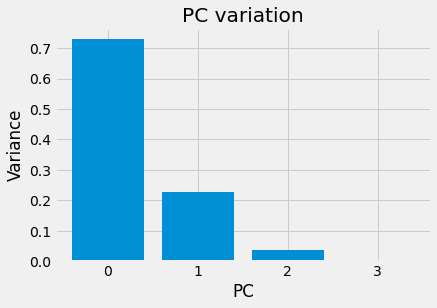

In [ ]:
  plt.bar(x=range(N_ATRIBUTES) , height=pca.explained_variance_ratio_)
  plt.ylabel("Variance")
  plt.xlabel("PC")
  plt.title("PC variation")
  plt.show()

Looks like PC0 and PC1 says more about the data, lets work with them

In [62]:
data = np.array(list(zip(pcs[:,0],pcs[:,1])))

In [110]:
columns = ["pc0", "pc1"]
data = pd.DataFrame(data,columns=columns)
data.insert(2,"target",list(iris.target))

Split the data

In [218]:
source, test = train_test_split(data, test_size=0.2)
source = source.reset_index(); test = test.reset_index()
len(source), len(test)

(120, 30)

In [322]:
targets = ["Setosa", "Versicolor", "Virginica"]
INTER = 5
BATCH = 20
error_rate = [0 for i in range(1, BATCH)]
for i in range(INTER):
  models = []
  for b in range(1,BATCH):
    models.append(KNN(b,data=source))
    for j in targets:
      models[b-1].stats[j] = Validation_stats(len(targets))
    models[b-1].validate(targets, test)
    error_rate[b-1]+=models[b-1].error_rate
  error_rate = np.array(error_rate) / INTER

Finding a good k value 

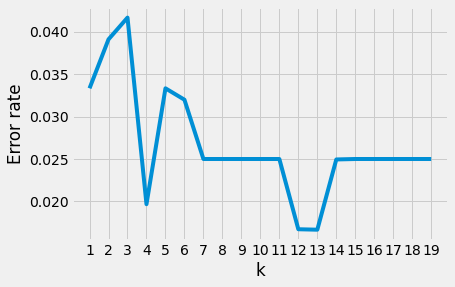

In [323]:
plt.plot(range(1, BATCH), error_rate,)
plt.xlabel("k")
plt.xticks(range(1, BATCH))
plt.ylabel("Error rate")
plt.show()

Lets work with 4, looks like a good number while not overfiting

In [326]:
model = models[3]

# **Result:**

In [329]:
for class_name in model.stats.keys():
  class_stats = model.stats[class_name]
  print(f"{class_name}:")
  print("Correct Predictions: ", class_stats.true_positives)
  for ind, tgt in enumerate(class_stats.false_positives_when):
    if tgt: print(f"Incorrect Predictions when it was {targets[ind]}:", tgt)
  print("\n")

Setosa:
Correct Predictions:  10


Versicolor:
Correct Predictions:  12


Virginica:
Correct Predictions:  6
Incorrect Predictions when it was Versicolor: 2


